In [1]:
 pip install -Uq langgraph langsmith langchain_groq langchain_tavily grandalf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.2/386.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.5 MB/s eta 0:00:00


In [ ]:
from os import environ
from google.colab import userdata

environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

environ["LANGCHAIN_TRACING_V2"] = "true"
environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
environ["LANGCHAIN_PROJECT"] = "05-LangGraph-Streaming-Outputs"

In [8]:
from langchain_tavily import TavilySearch

search = TavilySearch(max_results=3)

tools = [search]

In [56]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools = llm.bind_tools(tools=tools)

In [71]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]
  dummy_data: Annotated[str, "dummy_data"]

In [72]:
def chatbot(state: State) -> State:
  answer = llm_with_tools.invoke(state["messages"])
  return State(messages=[answer], dummy_data="[chatbot] 호출, dummy data")

In [30]:
tool_node = ToolNode(tools)

In [31]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [73]:
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile(checkpointer=memory)

In [33]:
print(graph.get_graph().draw_ascii())

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


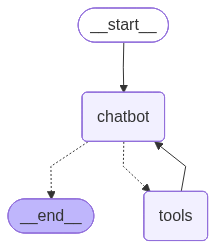

In [34]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [35]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-tag"],
)

In [58]:
input = {"messages": [("user", "2024년 노벨 문학상 관련 뉴스를 웹검색해서 알려주세요.")]}

for event in graph.stream(input, config):
  for key, value in event.items():
    print(f"\n[ {key} ]\n")
    if "messages" in value:
      # print(value)
      value["messages"][0].pretty_print()


[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_a9f4b2f6-a0ac-4f41-b1e9-808619b455cf)
 Call ID: fc_a9f4b2f6-a0ac-4f41-b1e9-808619b455cf
  Args:
    query: 2024년 노벨 문학상 한강 뉴스
    search_depth: advanced

[ tools ]

================================= Tool Message =================================
Name: tavily_search

{"query": "2024년 노벨 문학상 한강 뉴스", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://overseas.mofa.go.kr/se-ko/brd/m_7977/view.do?seq=1345639", "title": "한국 작가 한강, 2024년 노벨 문학상 수상 상세보기|공지사항", "content": "바로가기 메뉴\n본문 바로가기\n주메뉴 바로가기\n\n알림·소식\n\n 공지사항\n 다가오는 행사\n 대사관 활동\n\n## 공지사항\n\n2. 알림·소식\n3. 공지사항\n\n 글자크기\n\n## 한국 작가 한강, 2024년 노벨 문학상 수상\n\n작성자\n:   주 스웨덴 대사관\n\n작성일\n:   2024-10-11\n\n수정일\n:   2024-12-06\n\n스웨덴 한림원은 10.10(목) 2024년 노벨 문학상 수상자로 한국 작가 한강을 선정했습니다. 한림원 측은 “역사적 트라우마에 맞서고 인간 삶의 연약함을 드러낸 강렬한 시적 산문”을 선정 이유로 밝혔습니다.\n\n한국인 최초 노벨문학상 수상이자 아시아 여성 작가로서 최초 수상이라는 

In [46]:
input = {"messages": [("user", "2024년 노벨 문학상 관련 뉴스를 웹검색해서 알려주세요.")]}

for event in graph.stream(input, config):
  for key, value in event.items():
    if "messages" in value:
      print(value)
      print(1, value["messages"][0])
      print(2, value["messages"][-1])

{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': "The user keeps asking the same. We need to provide a summary with web search results. Already did. But they might want more recent. Let's search again.", 'tool_calls': [{'id': 'fc_4bea2ad5-f962-4ca2-b7b9-5ccee56ca9cc', 'function': {'arguments': '{"query":"2024 Nobel Prize Literature news 2024 October 10","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 15121, 'total_tokens': 15198, 'completion_time': 0.076436542, 'prompt_time': 0.082687401, 'queue_time': 0.116810075, 'total_time': 0.159123943, 'prompt_tokens_details': {'cached_tokens': 13824}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_64d94ab511', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--37091cee-67f7-4963-9cc0-850dfb4b99cd-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '2024 

In [49]:
input = {"messages": [("user", "2024년 노벨 문학상 관련 뉴스를 웹검색해서 알려주세요.")]}

for event in graph.stream(input, config):
  for key, value in event.items():
    if "messages" in value:
      value["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_ae4c20fd-5b9d-4d32-ac80-0a99837eaec2)
 Call ID: fc_ae4c20fd-5b9d-4d32-ac80-0a99837eaec2
  Args:
    query: 2024 Nobel Prize in Literature news
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "2024 Nobel Prize in Literature news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nobelprize.org/prizes/literature/2024/prize-announcement/", "title": "The Nobel Prize in Literature 2024 - Prize announcement", "content": "Skip to content \n\n# Prize announcement\n\nAnnouncement of the Nobel Prize in Literature 2024 to Han Kang by Mats Malm, Permanent Secretary of the Swedish Academy, on 10 October 2024. After the announcement Anders Olsson, chair of the Nobel Committee for Literature, presented the new laureate.\n\n### Interview about the awarded wor

In [59]:
print(graph.channels.keys())

dict_keys(['messages', 'dummy_data', '__start__', '__pregel_tasks', 'branch:to:chatbot', 'branch:to:tools'])


In [69]:
print(list(graph.channels.keys()))

['messages', 'dummy_data', '__start__', '__pregel_tasks', 'branch:to:chatbot', 'branch:to:tools']


In [74]:
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-tag"],
)

for event in graph.stream(input, config, output_keys=["dummy_data"]):
  for key, value in event.items():
    print(f"\n[ {key} ]\n")
    print(value)


[ chatbot ]

{'dummy_data': '[chatbot] 호출, dummy data'}

[ tools ]

None

[ chatbot ]

{'dummy_data': '[chatbot] 호출, dummy data'}


In [79]:
for event in graph.stream(input, config, stream_mode="values"):
    print("===" * 10, " 단계 ", "===" * 10)
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-tag"],
)        print(value)

==============================  단계  ==============================

[ messages ]

[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='2bf6c5aa-2215-4c11-b986-a58e639647cf'), AIMessage(content='', additional_kwargs={'reasoning_content': "User wants news about 2024 Nobel Prize in Literature. Need up-to-date info. We'll search.", 'tool_calls': [{'id': 'fc_56b98529-2b1a-4aee-9469-38105193d7d1', 'function': {'arguments': '{"include_favicon":false,"include_images":false,"query":"2024 Nobel Prize in Literature news","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 1370, 'total_tokens': 1439, 'completion_time': 0.061515657, 'prompt_time': 0.089395001, 'queue_time': 0.003103007, 'total_time': 0.150910658}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_02ab2edfdc', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'log

In [85]:
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "2"},
    tags=["my-tag"],
)

for event in graph.stream(
    input,
    config,
    stream_mode="updates",
    output_keys=["messages"],
    interrupt_before=["tools"]
):
  for key, value in event.items():
    print(f"\n[ {key} ]\n")
    print(value)


[ chatbot ]

{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "2024년 노벨 문학상 관련 뉴스를 웹검색해서 알려주세요." Need to search for news about the 2024 Nobel Prize in Literature. Likely announced in October 2024. Need recent news. Use search.', 'tool_calls': [{'id': 'fc_854b6880-bb00-4b41-aebe-95b77166b1d0', 'function': {'arguments': '{"query":"2024 Nobel Literature Prize news","search_depth":"advanced","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1373, 'total_tokens': 1475, 'completion_time': 0.202781717, 'prompt_time': 0.053156181, 'queue_time': 0.069306602, 'total_time': 0.255937898}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_51a297bede', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1a01b9dc-2a6b-43d5-a7e7-bdbcd99a7bd3-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '2024 Nobel Literatu